# CT Chest Image Analysis

We are going to use kaggle image dataset (https://www.kaggle.com/datasets/trainingdatapro/computed-tomography-ct-of-the-chest) to illustrate the data processing and model preparation. This model will then be used for analysis & classification of CT Chest images.

# All common imports

In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,Dropout
from tensorflow.keras.optimizers import RMSprop,Adam
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import Model
from tensorflow.keras import layers
import os

# Generic function to return training and validation dataset

In [2]:
# grader-required-cell

#The below function takes in the folder path of the training and validation subfolders as arguments

# GRADED FUNCTION: train_val_generators
def train_val_generators(DATA_DIR):
  """
  Creates the training and validation data generators

  Args:
    TRAINING_DIR (string): directory path containing the training images
    VALIDATION_DIR (string): directory path containing the testing/validation images

  Returns:
    train_generator, validation_generator - tuple containing the generators
  """
  ### START CODE HERE

  # Instantiate the ImageDataGenerator class (don't forget to set the arguments to augment the images)
  train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     validation_split=0.2, #This defines that validation data should be 20% of the whole dataset
                                     fill_mode='nearest')

  # Pass in the appropriate arguments to the flow_from_directory method
  train_generator = train_datagen.flow_from_directory(directory=DATA_DIR,
                                                      batch_size=50,
                                                      class_mode='categorical',
                                                      shuffle=True,
                                                      subset = 'training',
                                                      target_size=(224, 224))

  # Instantiate the ImageDataGenerator class (don't forget to set the rescale argument)
  validation_datagen = ImageDataGenerator(rescale=1.0/255.0, validation_split=0.2)

  # Pass in the appropriate arguments to the flow_from_directory method
  validation_generator = validation_datagen.flow_from_directory(directory=DATA_DIR,
                                                                batch_size=50,
                                                                class_mode='categorical',
                                                                shuffle=False,
                                                                subset = 'validation',
                                                                target_size=(224, 224))
  ### END CODE HERE
  return train_generator, validation_generator

In [3]:
#The images and classification folder doesn't have subfolders like training and validation andwe are going to split it in the
#train_val_generators method using ImageDatagenerator's property
DATA_DIR = "D:\\Kaggle-Competitions\\CT-Chest\\data\\files"
# Test your generators
train_generator, validation_generator = train_val_generators(DATA_DIR)

Found 748 images belonging to 6 classes.
Found 185 images belonging to 6 classes.


# Building a model 

In [16]:
# grader-required-cell

# GRADED FUNCTION: create_model
def create_model():
  ### Using the inception model as base while creating layers on top of it
  local_weights_file = './tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

  pre_trained_model = InceptionV3(input_shape = (224, 224, 3), 
                                include_top = False, 
                                weights = None)

  # Load the pre-trained weights you downloaded.
  pre_trained_model.load_weights(local_weights_file)

  # Freeze the weights of the layers.
  for layer in pre_trained_model.layers:
     layer.trainable = False

  # Choose `mixed7` as the last layer of your base model
  last_layer = pre_trained_model.get_layer('mixed7')
  #print('last layer output shape: ', last_layer.output_shape)
  last_output = last_layer.output

  # Flatten the output layer to 1 dimension
  x = layers.Flatten()(last_output)
  # Add a fully connected layer with 1,024 hidden units and ReLU activation
  x = layers.Dense(1024, activation='relu')(x)
  x = layers.Dropout(0.1)(x) #This is to minimize the model to overfit by randomly de-activating 10% of neurons
  x = layers.Dense(512, activation='relu')(x)
  # Add a dropout rate of 0.4
  x = layers.Dropout(0.4)(x)                  
  # Add a final sigmoid layer for classification
  x = layers.Dense  (17, activation='softmax')(x)    
    
  model = Model(pre_trained_model.input, x) 
  
  model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
  ### END CODE HERE

  return model

# Custom CNN Model for image analysis

In [4]:
def create_model1():
    model = tf.keras.models.Sequential([
        # Note the input shape is the desired size of the image 150x150 with 3 bytes color
        # This is the first convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(224, 224, 3)),
        tf.keras.layers.MaxPooling2D(2, 2),
        # The second convolution
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The third convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # The fourth convolution
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        # Flatten the results to feed into a DNN
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dropout(0.2),
        # 512 neuron hidden layer
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(6, activation='softmax')
    ])
    
    #model compilation
    model.compile(optimizer=Adam(),
                loss='categorical_crossentropy',
                metrics=['accuracy'])
    return model



# Train the model

In [6]:
# Get the untrained model
model = create_model1()

# Train the model
# Note that this may take some time.
history = model.fit(train_generator,
                    epochs=15,
                    verbose=1,
                    validation_data=validation_generator)

Epoch 1/15
15/15 [==============================] - 41s 3s/step - loss: 1.4637 - accuracy: 0.3449 - val_loss: 0.9060 - val_accuracy: 0.5189
Epoch 2/15
15/15 [==============================] - 39s 3s/step - loss: 1.0450 - accuracy: 0.4612 - val_loss: 0.7855 - val_accuracy: 0.5568
Epoch 3/15
15/15 [==============================] - 40s 3s/step - loss: 0.8856 - accuracy: 0.5642 - val_loss: 0.6919 - val_accuracy: 0.6703
Epoch 4/15
15/15 [==============================] - 39s 3s/step - loss: 0.7981 - accuracy: 0.6136 - val_loss: 1.2263 - val_accuracy: 0.4432
Epoch 5/15
15/15 [==============================] - 39s 3s/step - loss: 0.7638 - accuracy: 0.6390 - val_loss: 0.5499 - val_accuracy: 0.6811
Epoch 6/15
15/15 [==============================] - 39s 3s/step - loss: 0.6544 - accuracy: 0.7179 - val_loss: 0.7030 - val_accuracy: 0.7027
Epoch 7/15
15/15 [==============================] - 40s 3s/step - loss: 0.5124 - accuracy: 0.7567 - val_loss: 0.8746 - val_accuracy: 0.6757
Epoch 8/15
15/15 [==

# Plot the accuracy

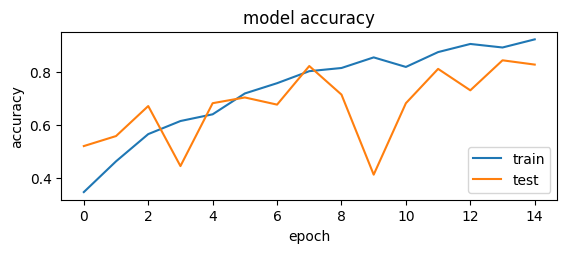

In [7]:
import matplotlib.pyplot as plot
plot.subplot(2,1,1)
plot.plot(history.history['accuracy'])
plot.plot(history.history['val_accuracy'])
plot.title('model accuracy')
plot.ylabel('accuracy')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='lower right')

# Plot the loss


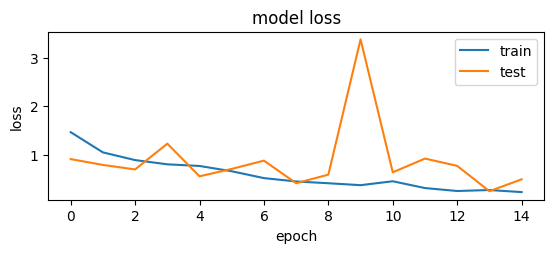

In [8]:
plot.subplot(2,1,2)
plot.plot(history.history['loss'])
plot.plot(history.history['val_loss'])
plot.title('model loss')
plot.ylabel('loss')
plot.xlabel('epoch')
plot.legend(['train', 'test'], loc='upper right')

In [9]:
inference_labels = os.listdir("D:\\Kaggle-Competitions\\CT-Chest\\data\\files")
print(inference_labels)

['aortic_aneurysm', 'broken_ribs', 'cancer', 'covid_19', 'signs_of_ihd', 'tuberculosis']


# Make predictions using above model

1/1 [==============================] - 0s 35ms/step


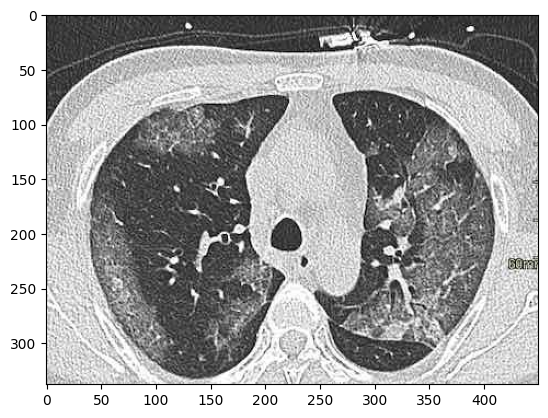

Inference is covid_19


In [14]:
from tensorflow.keras.utils import load_img, img_to_array
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np

fn="covi1.jpeg"
#image_path='D:\\Kaggle-Competitions\\CT-Chest\\test\\' + fn
image_path= os.path.join(os.path.dirname("D:\\Kaggle-Competitions\\CT-Chest\\test\\"),fn)

image = tf.keras.utils.load_img(image_path, target_size=(224, 224))
x=img_to_array(image)
x /= 255.0
x=np.expand_dims(x, axis=0)
classes = model.predict(x)

img = mpimg.imread(image_path)
plt.imshow(img)

plt.show()

category=np.array(classes[0]).argmax()
print("Inference is " + inference_labels[category])
